In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import json

from selenium.webdriver.common.by import By

from visca.browser import (
    create_driver,
    ensure_page_loaded,
    capture_full_page_screenshot,
    get_element_xpath,
)
from visca.element_extractor import (
    extract_elements_from_driver,
    save_elements
)
from visca.dedup import deduplicate_screenshots
from visca.virtual_node import (
    build_dom_tree,
    VirtualNode,
    ComponentType
)

from visca.llm.gemini import create_model
from visca.prompts import (
    PAGE_CONTEXT_EXTRACTION_SYSTEM_PROMPT,
    CLASSIFICATION_AND_CONTEXT_PROMPT,
    COMPONENT_GENERATION_PROMPT,
)
from visca.llm_processing import (
    _get_ancestor_context,
    classify_and_describe_candidates,
    transform_candidate
)

# Initialization

In [3]:
# APP_NAME = os.getenv("APP_NAME")
APP_NAME = "ADMIN"
DIR = f'segmentation_results/{APP_NAME}'

In [25]:
driver = create_driver(headless=True)

In [26]:
driver.get('http://localhost:3007/')

In [27]:
driver.find_element(By.XPATH, '//BODY/DIV[1]/MAIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/DIV[2]/DIV[1]/INPUT[1]').send_keys('admin@example.com')
driver.find_element(By.XPATH, '//BODY/DIV[1]/MAIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/DIV[4]/DIV[1]/DIV[1]/INPUT[1]').send_keys('admin')
driver.find_element(By.XPATH, '//BODY/DIV[1]/MAIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/DIV[5]/BUTTON[1]').click()
ensure_page_loaded(driver, 10)

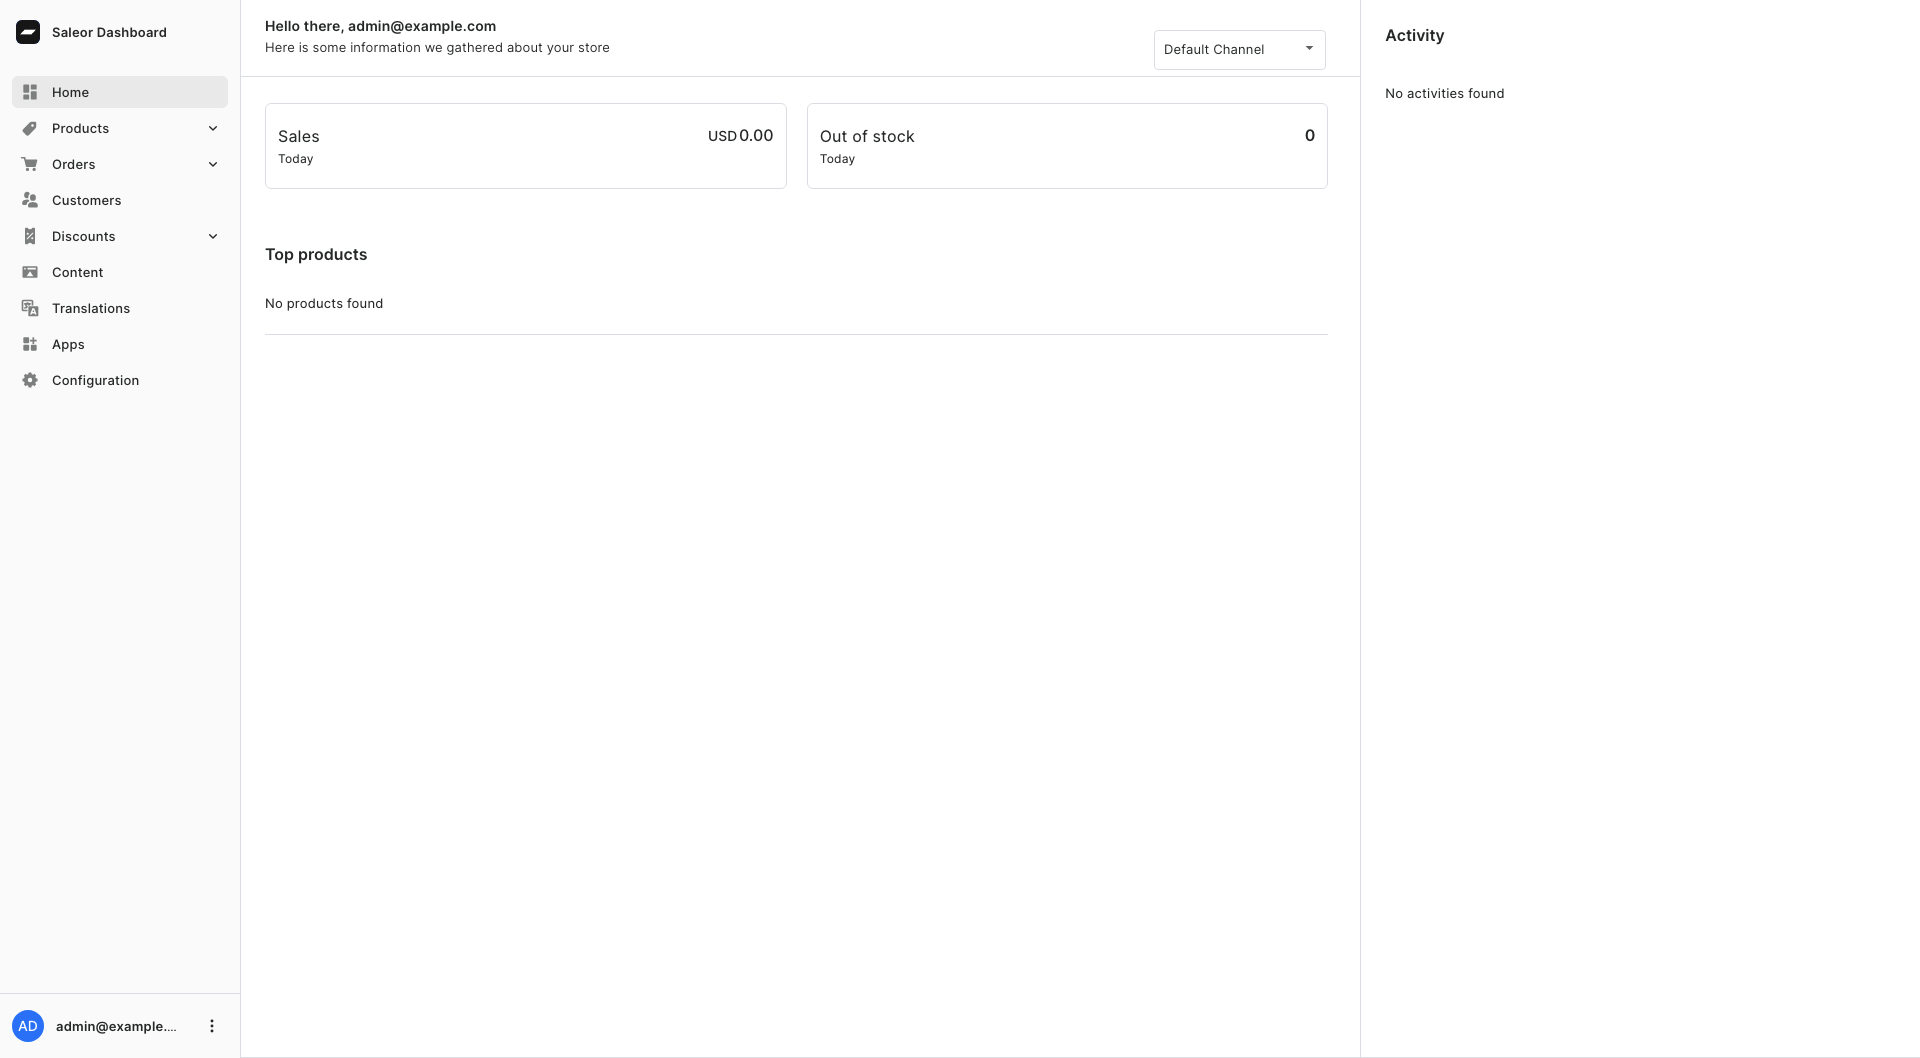

In [28]:
capture_full_page_screenshot(driver)

# Initialize Model

In [5]:
def get_state_route(nodes, state_id):
    curr_state = nodes[state_id]
    prev_actions = [curr_state['prev_action']]
    
    while True:
        prev_state_id = curr_state['prev_state']

        if prev_state_id is None:
            break
        
        curr_state = nodes[prev_state_id]
        prev_actions.append(curr_state['prev_action'])

    prev_actions = list(filter(lambda x: x is not None, reversed(prev_actions)))
    
    return curr_state, prev_actions

In [6]:
FORM_FILLING_PROMPT = """
Given a form element in a web application, your task is to generate a set of values so that the form can be submitted successfully.
Your response should be a direct, executable Selenium script in Python. Imagine that we have the root "form" Selenium element saved in a variable called `form`. After filling the form with values, submit the form as well.

If the given form is a login form, use the following information to log in:
Username: admin@example.com
Password: admin
""".strip()

form_filling_model = create_model(FORM_FILLING_PROMPT, thinking=True)


def get_to_state(driver, initial_state, action_route):
    driver.get(initial_state['url'])
    ensure_page_loaded(driver, 10)

    for action in action_route:
        element = None
        print(action)
        try:
            try:
                element = driver.find_element(By.XPATH, action['id'])
            except:
                element = driver.find_element(By.ID, action['id'])

            print(element)
            
            if action['type'] == 'click':
                element.click()
                print('clicked')
            else:
                form = element
                res = form_filling_model(prompt=action['outerHTML']).text.replace('```python', '').replace('```', '')
                exec(res)
                print('filled')
        except:
            continue
            
        ensure_page_loaded(driver, 10)


def get_to_state_url(driver, final_state_url, action_route):
    driver.get(final_state_url)
    ensure_page_loaded(driver, 10)

    for action in action_route:
        element = None
        print(action)
        try:
            try:
                element = driver.find_element(By.XPATH, action['id'])
            except:
                element = driver.find_element(By.ID, action['id'])

            print(element)
            
            if action['type'] == 'click':
                element.click()
                print('clicked')
            else:
                form = element
                res = form_filling_model(prompt=action['outerHTML']).text.replace('```python', '').replace('```', '')
                exec(res)
                print('filled')
        except:
            continue
            
        ensure_page_loaded(driver, 10)

In [7]:
try:
    model = json.load(open(f'{DIR}/model.json'))
    print('pre-loaded')
except:
    model = json.load(open(f'./models/{APP_NAME.split('-')[0]}.json'))
    print('from scratch')

from scratch


In [8]:
queue = [list(model['nodes'].keys())[0]]

model['nodes'][queue[0]]['depth'] = 0
model['nodes'][queue[0]]['prev_action'] = None
model['nodes'][queue[0]]['prev_state'] = None

for state_id, edges in model['edges'].items():
    for action_id, target_state_id in edges.items():
        # print(state_id, target_state_id)
        model['nodes'][target_state_id]['prev_state'] = state_id
        # print(action_id)
        model['nodes'][target_state_id]['prev_action'] = list(filter(
            lambda x: x['id'] == action_id,
            model['nodes'][state_id]['actions']
        ))[0]
        model['nodes'][target_state_id]['depth'] = model['nodes'][state_id]['depth'] + 1

# Transform Pages

In [9]:
def find_all_components(root: VirtualNode):
    queue = [root]
    components = []

    while len(queue) > 0:
        node = queue[0]
        
        if node.component_info.component_type != ComponentType.CONTAINER:
            components.append(node)
        else:
            queue.extend(node.children)

        queue = queue[1:]

    return components

In [10]:
def get_hierarchy(node: VirtualNode):
    titles = []
    contexts = []
    
    parent = node.parent
    
    while parent.data.tag_name != 'root' and parent is not None:
        titles.append(parent.component_info.component_title)
        contexts.append(parent.component_info.component_context)
        parent = parent.parent

    titles = list(filter(lambda x: x is not None, reversed(titles)))
    contexts = list(filter(lambda x: x is not None, reversed(contexts)))
    
    return ' > '.join(titles), '\n'.join(contexts)

In [11]:
def authenticate(driver):
    # if APP_NAME == 'DIMESHIFT':
    #     driver.get('http://localhost:30000/')
    #     ensure_page_loaded(driver, 10)
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/UL[1]/LI[7]/A[1]').click()
    #     time.sleep(1)
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[3]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/FORM[1]/FIELDSET[1]/DIV[1]/INPUT[1]').send_keys('parsaalian0@gmail.com')
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[3]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/FORM[1]/FIELDSET[1]/DIV[2]/INPUT[1]').send_keys('testtest')
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[3]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/FORM[1]/FIELDSET[1]/DIV[4]/INPUT[1]').click()
    #     return
    # if APP_NAME == 'TRADUORA':
    #     driver.get('http://localhost:8080/login')
    #     ensure_page_loaded(driver, 10)
    #     driver.find_element(By.XPATH, '//BODY[1]/APP-ROOT[1]/DIV[1]/DIV[1]/APP-LOGIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/DIV[1]/INPUT[1]').send_keys('parsaalian1@gmail.com')
    #     driver.find_element(By.XPATH, '//BODY[1]/APP-ROOT[1]/DIV[1]/DIV[1]/APP-LOGIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/DIV[2]/INPUT[1]').send_keys('testtest')
    #     driver.find_element(By.XPATH, '//BODY[1]/APP-ROOT[1]/DIV[1]/DIV[1]/APP-LOGIN[1]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/BUTTON[1]').click()
    #     return
    # if APP_NAME == 'TASKCAFE':
    #     driver.get('http://localhost:3333/login')
    #     ensure_page_loaded(driver, 10)
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/DIV[1]/DIV[1]/FORM[1]/LABEL[1]/INPUT[1]').send_keys('parsaalian')
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/DIV[1]/DIV[1]/FORM[1]/LABEL[2]/INPUT[1]').send_keys('testtest')
    #     driver.find_element(By.XPATH, '//BODY[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[2]/DIV[1]/DIV[1]/FORM[1]/DIV[1]/BUTTON[2]').click()
    #     return

    # driver.get('https://mantisbt.org/bugs/login_page.php?return=%2Fbugs%2Fmy_view_page.php')
    # ensure_page_loaded(driver, 10)
    
    # driver.find_element(By.XPATH, '//BODY/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[4]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/FIELDSET[1]/LABEL[1]/SPAN[1]/INPUT[1]').send_keys('parsaalian7@gmail.com')
    # driver.find_element(By.XPATH, '//BODY/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[4]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/FIELDSET[1]/INPUT[2]').click()
    # ensure_page_loaded(driver, 10)

    # driver.find_element(By.XPATH, '//BODY/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[4]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/FIELDSET[1]/LABEL[1]/SPAN[1]/INPUT[1]').send_keys('paap9009')
    # driver.find_element(By.XPATH, '//BODY/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[1]/DIV[4]/DIV[1]/DIV[1]/DIV[1]/FORM[1]/FIELDSET[1]/INPUT[3]').click()
    # ensure_page_loaded(driver, 10)
    pass

In [12]:
MEMORY = {}
# AUTHENTICATED = False

In [29]:
for state_id in model['nodes']:
# for state_id in [
#     'b79d56430869ae9fdcd1e89f3de2869ff46a209de1c94b0bf7a288dbf06844bb',
#     '6dbc95fdd5ab4f75960a9700fcf90473e1cc2bfb55016ef36d9c79d41758ce77',
#     'fd1bfa12fd12c91ec109d84207af55967e4248951e597c5b92b1fcc2cc22b92c',
#     'e3ee87a7a1a57d9ff6290675a02299e1958efa9dd9b792201525e41a33cdbe76',
# ]:
    print(state_id)
    if 'components' in model['nodes'][state_id]:
        continue
    
    RESULT_DIR = f'{DIR}/{state_id}'
    
    # initial_state, action_route = get_state_route(model['nodes'], state_id)
    # get_to_state(driver, initial_state, action_route)

    # ensure_page_loaded(driver, 10)

    # if driver.current_url != model['nodes'][state_id]['url']:
    #     # driver.get(model['nodes'][state_id]['url'])
    #     get_to_state_url(driver, model['nodes'][state_id]['url'], action_route)
    driver.get(model['nodes'][state_id]['url'])
    
    ensure_page_loaded(driver, 10)
    
    dom_elements = extract_elements_from_driver(driver)

    dom_elements_with_screenshot = save_elements(
        driver=driver,
        result_dir=RESULT_DIR,
        dom_elements=dom_elements
    )
    
    dom_elements_with_screenshot = list(filter(lambda x: 'screenshot' in x, dom_elements_with_screenshot))

    deduplicated_elements = deduplicate_screenshots(dom_elements_with_screenshot)

    reduced_tree = build_dom_tree(deduplicated_elements)

    screenshot = capture_full_page_screenshot(driver)
    screenshot.save(f'{RESULT_DIR}/screenshot.png')

    page_context_model = create_model(PAGE_CONTEXT_EXTRACTION_SYSTEM_PROMPT)
    page_context = page_context_model(file=f'{RESULT_DIR}/screenshot.png').text

    classification_model = create_model(CLASSIFICATION_AND_CONTEXT_PROMPT , settings={'temperature': 0})

    classified_tree = classify_and_describe_candidates(
        root=reduced_tree,
        classification_model=classification_model,
        page_context=page_context,
        memory=MEMORY
    )

    component_generation_model = create_model(COMPONENT_GENERATION_PROMPT)

    MEMORY, transformed_tree = transform_candidate(
        root=classified_tree,
        component_generation_model=component_generation_model,
        page_context=page_context,
        memory=MEMORY,
        state_id=state_id
    )

    page_code = transformed_tree.component_info.get_component_code()

    with open(f'{RESULT_DIR}/transformed.jsx', 'w', encoding='utf-8') as f:
        f.write(page_code)

    components = find_all_components(transformed_tree)

    component_model = []
    
    for component in components:
        htitles, hcontexts = get_hierarchy(component)
        component_model.append({
            'id': component.data.xpath,
            'htitles': htitles,
            'hcontexts': hcontexts,
            'title': component.component_info.component_title,
            'context': component.component_info.component_context,
            'code': component.component_info.component_code,
            'original_state': component.component_info.previously_seen,
        })

    model['nodes'][state_id]['context'] = page_context
    model['nodes'][state_id]['components'] = component_model
    
    print()

3a9a0cc95faadb210453ae06e176340513c3b2fd4ac65ae6d0f81afdae9340dc
d4fe71be2d1ea909d26824e119e8dc7898bbbacb0b2501c8b8baec6632e93167
f3da9e519a1a495ba0b9e0d8501cc460495b087624abd9f91180ebf647b3126b
ee81ed1f1d52ac339073c34c02eee05f139eb8d03ca59609234f1cbc385a5044
e848ec2cd5b4b14a62e36b0dd6c7fa98c114726cdc001ab78ce7a9b99879b4e3
68d4f6dc0ed42ecf1673940e5e2ff9892d4c026f6999a359e9cbfe7fb7209d82
b0ef18c18d800bafc99a2c1cba00d95387de83264787109918c3ffb0bc38a520
7f7fec047a1d985ce1450e1f83a24e0ce87b58a0032501544d4e68581f2e6be6
d6e18e9bf5e614af7cabb4e0a366dd7f1ccebc96be5af1ebe0e0d72368dfb817
6a0dffc680d4de05bcf8e7fe785b98d0ed5e45556a58afbbcd6e45e9cf1d491f
ff039e6a2058d8b58b31a686eb47771931379f306331ce797257011b59a1cd2f
1b692a8eec6c2cdf1945bf01795f65f2cdc82c769e2893af35c7638819e64a18
336464f00863ba569de94d538234cc9a7ebb108f007daac094f2cd00c8e3b321
884423f31286201a69505181026c0d77d5e12271c3b842527dad8860e4cb2e27
ab99af99285ee6078ff39301ac45fddec0d79cf9c91bb64118d76cc11cb64925
0a7bd3b0959273289643e2d56

In [24]:
# del model['nodes']['b43f7e97e031eaa691de9183ca74b5b723bcaee9f393cee0591597871832628e']['components']

KeyError: 'components'

In [30]:
with open(f'{DIR}/model.json', 'w') as f:
    json.dump(model, f)